In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns

In [2]:
df = pd.read_csv('train.csv')

In [61]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, f1_score, confusion_matrix, accuracy_score
from sklearn.impute import KNNImputer
from collections import Counter
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import SelectKBest, chi2, SelectFromModel

In [8]:
numeric = ['cust_balance', 'campaign', 'contact_duration', 'pdays', 'customer_id',
           'previous_contacts', 'cust_age',]

categorical = ['marital_status', 'education', 'has_default_loan', 'job_title',
               'contact_channel', 'contact_month', 'contact_day',
               'has_personal_loan', 'has_mortgage_loan', 'previous_outcome']

In [14]:
df[['cust_age','cust_balance']] = df[['cust_age','cust_balance']].astype(str)

df['cust_age'] = df['cust_age'].map(lambda df: df.rstrip('/r').rstrip('/'))
df['cust_balance']= df['cust_balance'].map(lambda df: df.rstrip('/r').lstrip('/'))

df['cust_balance'] = df['cust_balance'].str.extract('(\d+)', expand=False)
df['cust_balance']= df['cust_balance'].astype(float)

df['contact_day'] = df['contact_day'].astype(str)

df['cust_age'] = df['cust_age'].str.extract('(\d+)', expand=False)
df['cust_age'] = df['cust_age'].astype(float)
df['contact_day'] = df['contact_day'].astype(float)

In [15]:
X = df[numeric+categorical]
y = df['is_subscribed']

In [16]:
rus = RandomUnderSampler()
X_rus, y_rus = rus.fit_resample(X, y)
Counter(y_rus)

Counter({False: 3693, True: 3693})

In [ ]:
## Catboost
sss = StratifiedKFold()
f1 = []
pipe = Pipeline(steps=[
        ('preprocessing', ColumnTransformer(transformers=[
            ('numeric', Pipeline(steps=[
                ('impute', SimpleImputer(strategy='mean')),
                ('scale', StandardScaler())
            ]), numeric),
            ('categorical', Pipeline(steps=[
                ('impute', SimpleImputer(strategy='most_frequent')),
                ('ohe', OneHotEncoder())
            ]), categorical),
        ])),
#         ('skb', SelectKBest(chi2, k = 10)),
        ('classifier', CatBoostClassifier(od_type='Iter', od_wait=20, 
                           class_weights=[0.11, 0.89], 
                           learning_rate=0.08,
                           verbose=False, 
                           depth=12, 
                           iterations=400,))
    ])
for train_idx, test_idx in sss.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    pipe.fit(X_train, y_train)
    y_predicted=pipe.predict(X_test)
    y_predicted = pd.Series(y_predicted).apply(lambda x: True if x=='True' else False)
    f_score = f1_score(y_test, y_predicted)
    print(f_score)
    f1.append(f_score)

print("F1", np.mean(f1))

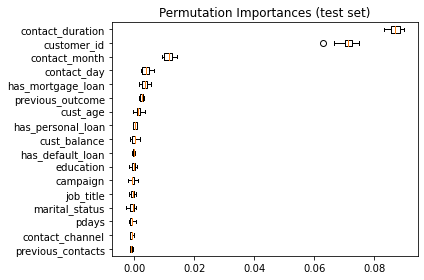

In [58]:
# ohe = (pipe.named_steps['preprocess']
#          .named_transformers_['cat'])
# feature_names = ohe.get_feature_names(input_features=categorical)
# feature_names = np.r_[feature_names, numeric]

# tree_feature_importances = (
#     pipe.named_steps['classifier'].feature_importances_)
# sorted_idx = tree_feature_importances.argsort()

# y_ticks = np.arange(0, len(feature_names))
# fig, ax = plt.subplots()
# ax.barh(y_ticks, tree_feature_importances[sorted_idx])
# ax.set_yticks(y_ticks)
# ax.set_yticklabels(feature_names[sorted_idx])
# ax.set_title("Random Forest Feature Importances (MDI)")
# fig.tight_layout()
# plt.show()


result = permutation_importance(pipe, X_test, y_test.astype(str), n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_test.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

In [ ]:
0.07 

In [20]:
## Catboost
sss = StratifiedKFold()
f1 = []
pipe = Pipeline(steps=[
        ('preprocessing', ColumnTransformer(transformers=[
            ('numeric', Pipeline(steps=[
                ('impute', SimpleImputer(strategy='mean')),
                ('scale', StandardScaler())
            ]), numeric),
            ('categorical', Pipeline(steps=[
                ('impute', SimpleImputer(strategy='most_frequent')),
                ('ohe', OneHotEncoder())
            ]), categorical),
        ])),
        ('classifier', RandomForestClassifier())
    ])
for train_idx, test_idx in sss.split(X_rus, y_rus):
    X_train, X_test = X_rus.iloc[train_idx], X_rus.iloc[test_idx]
    y_train, y_test = y_rus.iloc[train_idx], y_rus.iloc[test_idx]
    pipe.fit(X_train, y_train)
    y_predicted=pipe.predict(X_test)
#     y_predicted = pd.Series(y_predicted).apply(lambda x: True if x=='True' else False)
    f_score = f1_score(y_test, y_predicted)
    print(f_score)
    f1.append(f_score)

print(np.mean(f1))

0.8754034861200775
0.8763297872340426
0.8888888888888888
0.8906148867313917
0.8787684413085309
0.8820010980565863


In [21]:
test_df = pd.read_csv('test.csv')

In [22]:
test_df[['cust_age','cust_balance']] = test_df[['cust_age','cust_balance']].astype(str)

test_df['cust_age'] = test_df['cust_age'].map(lambda test_df: test_df.rstrip('/r').rstrip('/'))
test_df['cust_balance']= test_df['cust_balance'].map(lambda test_df: test_df.rstrip('/r').lstrip('/'))

test_df['cust_balance'] = test_df['cust_balance'].str.extract('(\d+)', expand=False)
test_df['cust_balance']= test_df['cust_balance'].astype(float)

test_df['cust_age'] = test_df['cust_age'].str.extract('(\d+)', expand=False)

In [23]:
testX = test_df[numeric+categorical]

In [47]:
result = pipe.predict(testX)
result = pd.Series(result).apply(lambda x: True if x=='True' else False)

In [48]:
submission = pd.read_csv('sample_submission.csv')

In [49]:
submission['is_subscribed'] = result

In [50]:
submission.to_csv('submissions/elshan/submission_elshan_15.csv', index=False)